In [1]:
import numpy as np
import sys
import pathlib
from os.path import join
path_to_file = str(pathlib.Path().resolve())
dir_path = join(path_to_file)

sys.path.append(join(dir_path, "HelperFiles"))
import helper
import retrospective
import top_k 
import train_models
import load_data 

from os.path import join
data_path = join(dir_path, "Experiments", "Data")

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import binom
import importlib

In [5]:
dataset = "census" #breast_cancer
X_train, y_train, X_test, y_test, mapping_dict = load_data.load_data(data_path, dataset)
model = train_models.train_model(X_train, y_train, "nn", lime=False)

print("Class imbalance: {}%".format(round(100*(max(np.mean(y_test), 1-np.mean(y_test))))))
Y_preds = (model(X_test) > 0.5).astype("int")
print("NN {}% accuracy".format(round(np.mean(Y_preds == y_test)*100)))
d = len(mapping_dict) if mapping_dict is not None else X_train.shape[1]
print(d)

Class imbalance: 75%
NN 82% accuracy
12


In [19]:
np.random.seed(1)
xloc = X_test[3]
shap_vals, n_verified, kshap_covs = retrospective.kernelshap(model, X_train, xloc, n_perms=1000, 
                                                n_samples_per_perm=10, mapping_dict=mapping_dict,
                                                alphas=[0.05, 0.1, 0.2], abs=True)
n_verified

[2, 3, 4]

# Ongoing runs
## Retrospective rank verification
### Shapley Sampling and KernelSHAP, various alphas. Both always control FWER!

In [2]:
import pickle
results_path = join(dir_path, "Experiments", "Results")
retro_path = join(results_path, "Retrospective")
method = "kernelshap"
dataset = "census"
with open(join(retro_path, method+"_"+dataset), 'rb') as f:
    retro_results = pickle.load(f)
shap_vals = retro_results["shap_vals"]
N_verified_all = retro_results["N_verified"]
shap_vars = retro_results["shap_vars"]

In [5]:
# Number of stable ranks from retrospective procedure. 
importlib.reload(helper)
alphas = [0.05, 0.1, 0.2]
print("Alphas:\t", alphas)
all_ranks = helper.shap_vals_to_ranks(shap_vals, abs=True)

N_pts, N_runs, N_alphas = N_verified_all.shape
print(N_verified_all.shape)
avg_shap = np.mean(shap_vals, axis=1)
avg_ranks = np.array([helper.get_ranking(avg_shap[i], abs=True) for i in range(N_pts)])

fwers = helper.calc_all_retro_fwers(N_verified_all, all_ranks, avg_ranks)
print("Max:\t", np.round(np.nanmax(fwers, axis=1), 3))
print("Mean:\t", np.round(np.nanmean(fwers, axis=1), 3))


Alphas:	 [0.05, 0.1, 0.2]
(30, 50, 3)
Max:	 [0.02 0.02 0.1 ]
Mean:	 [0.004 0.008 0.021]


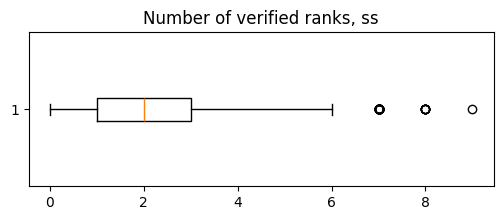

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,2))
plt.title("Number of verified ranks, " + method)
plt.boxplot(N_verified_all.reshape(-1), vert=False)
plt.show()

## Retrospective rank verification for top K set
### Looks fine!
- Had to fix a bit, with wrong def of FWER. 
- One instance where max FWER is higher than alpha, but it's really not unreasonable to see at least this many errors in 50 samples
<!-- - works across K, alpha
- possible exception: K=5, alpha=0.2, get FWER of 57% when skip_thresh < 0.3. Hard at the boundary here; only rejects 14/50 times. Empirical FWER is very high, 0.38. So it may just be too variable to gauge.
    - Kind of a bummer for analysis: "Hey our method works unless it's a boundary case, in which case it should be taken with a grain of salt... but there's no way of knowing whether it's a boundary case without rerunning a bunch of times" -->


In [6]:
importlib.reload(top_k)
importlib.reload(helper)
K = 5
alphas = [0.05, 0.1, 0.2]
# skip_thresh = 0.2
for alpha in alphas:
    fwers_all = []
    for i in range(N_pts):
        num_false_rejections = 0
        true_top_K_set = np.sort(avg_ranks[i,:K])
        for j in range(N_runs):
            ss_vals, ss_vars = shap_vals[i,j,:], shap_vars[i,j,:]
            result = helper.test_top_k_set(ss_vals, ss_vars, K=K, alpha=alpha, abs=True)
            if result=="reject":
                est_top_K_set = np.sort(all_ranks[i,j,:K])
                if not np.array_equal(true_top_K_set, est_top_K_set):
                    num_false_rejections += 1
        fwer = num_false_rejections/N_runs
        fwers_all.append(fwer)
    print(f"Alpha: {alpha} \tAverage FWER (out of {len(fwers_all)}): {np.mean(fwers_all):.3f} \tMax FWER: {np.max(fwers_all):.3f}")
    break

Alpha: 0.05 	Average FWER (out of 30): 0.005 	Max FWER: 0.080


In [7]:
from scipy.stats import binom
prob_get_that_max = 1-binom.cdf((50*0.08-1), 50, 0.05)
print(f"{prob_get_that_max:.3f}")


0.240


In [8]:

# helper.calc_fwer(np.sort(all_ranks[i,:,:K], axis=1))

# Top-K
## Rank stability
### from rankshap_vs_ss.py
<!-- - alpha = 0.2: Always controls FWER for K=2 and K=5, didn't let finish, fairly conservative
- alpha = 0.1: Generally good. Didn't let K=5 finish. 1x on each K, get  FWER > alpha, but by a margin that's not unlikely.  -->

- Just changed so it saves the iterations that fail to converge, and computes FWER based on both.
- haven't run for alpha=0.2 or 0.1 w/ K=5.

In [9]:
alpha = 0.1
top_k_path = join(results_path, "Top_K", "rank", "alpha_" + str(alpha))
K = 2
fname = "rankshap_vs_ss_k" + str(K)

with open(join(top_k_path, fname), 'rb') as f:
    results = pickle.load(f)
print(results.keys())


dict_keys(['rankshap', 'rankshap_rejection_idx', 'ss_adaptive', 'rankshap_n_samples', 'x_indices'])


In [13]:
top_K_rs = results['rankshap']
rejection_idx = results['rankshap_rejection_idx'] # Doesn't exist yet

print(len(top_K_rs))
print([helper.calc_fwer(top_K, digits=3, rejection_idx=rejection_idx[i]).item() for i, top_K in enumerate(top_K_rs)])

6
[0.0, 0.0, 0.0, 0.0, 0.04, 0.0]


### top_k_experiment.py
<!-- OUTDATED:
- RankSHAP alpha=0.1: Always controls FWER, not too conservative, made it to 30, and fixed saving error with FWERs
- RankSHAP alpha=0.2: Good but didn't make it to 30
- SPRT-SHAP alpha=0.1: Good but didn't make it to 30; conservative -->

In [40]:
alpha = 0.1
top_k_path = join(results_path, "Top_K", "rank", "alpha_" + str(alpha))
K = 2
# fname = "rankshap_census_K" + str(K)
fname = "sprtshap_census_K" + str(K)

with open(join(top_k_path, fname), 'rb') as f:
    results = pickle.load(f)

# top_K_all = results['ranks']
# idx = results['rejection_idx'] #
# fwers = np.array([helper.calc_fwer(top_K, digits=3, rejection_idx=idx[i]).item() for i, top_K in enumerate(top_K_all)])
results['fwers']

array([0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  ])

In [ ]:
print('hello')

In [ ]:
# fwers = results['fwers']

# fwers = results['fwers'].item()
# fwers = np.array(list(fwers.values()))
# results['fwers'] = fwers
# with open(join(top_k_path, fname), 'wb') as f:
#     pickle.dump(results, f)
# fwers

